In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore')
import time

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

# 머신러닝(사이킷런)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


# 다중공선성 / confusion matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix

# 정규화 도구
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer

# 분류 정확도
from sklearn.metrics import accuracy_score

### 1. 데이터 EDA 및 전처리

In [2]:
# data loding
data = pd.read_csv('OES_GasTool_Data_Class.csv')

In [3]:
data.head(3)

,685 nm,703 nm,775 nm,357 nm,844 nm,750 nm,603 nm,425 nm,SF6 gas flow,Ar gas flow,O2 gas flow,Class
0,2224,2938,2040,5428,862,2356,1298,3246,175.9644,9.933472,124.0082,1
1,2184,2878,1962,5260,834,2352,1272,3176,175.9644,10.040280,123.9899,1
2,2162,2896,2006,5356,824,2370,1292,3232,175.9338,9.994507,123.9990,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3010 entries, 0 to 3009
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   685 nm        3010 non-null   int64  
 1   703 nm        3010 non-null   int64  
 2   775 nm        3010 non-null   int64  
 3   357 nm        3010 non-null   int64  
 4   844 nm        3010 non-null   int64  
 5   750 nm        3010 non-null   int64  
 6   603 nm        3010 non-null   int64  
 7   425 nm        3010 non-null   int64  
 8   SF6 gas flow  3010 non-null   float64
 9   Ar gas flow   3010 non-null   float64
 10  O2 gas flow   3010 non-null   float64
 11  Class         3010 non-null   int64  
dtypes: float64(3), int64(9)
memory usage: 282.3 KB


In [5]:
data.isnull().sum()

685 nm          0
703 nm          0
775 nm          0
357 nm          0
844 nm          0
750 nm          0
603 nm          0
425 nm          0
SF6 gas flow    0
Ar gas flow     0
O2 gas flow     0
Class           0
dtype: int64

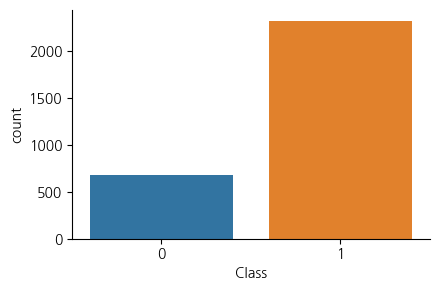

In [6]:
sns.catplot(x="Class", kind="count", data=data, height=3, aspect=1.5)

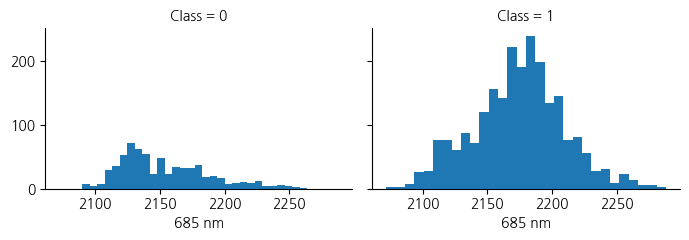

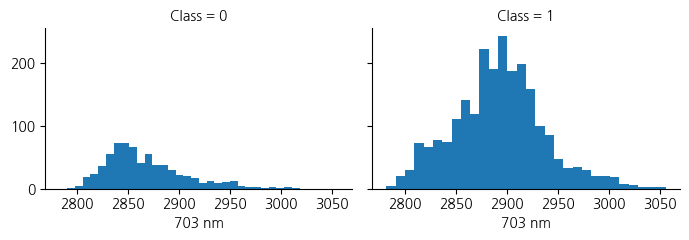

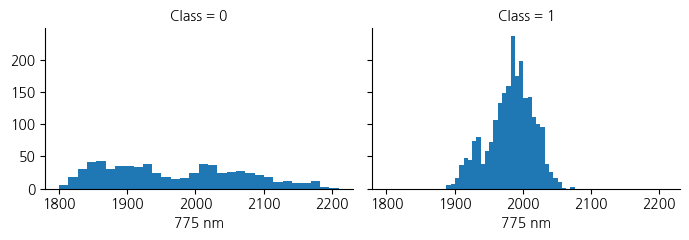

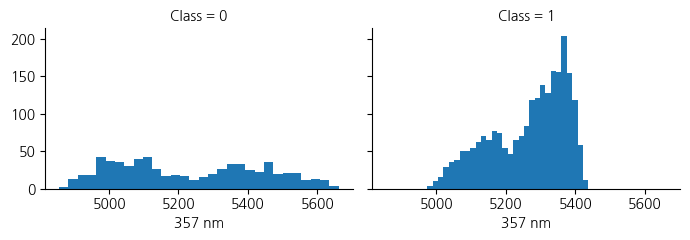

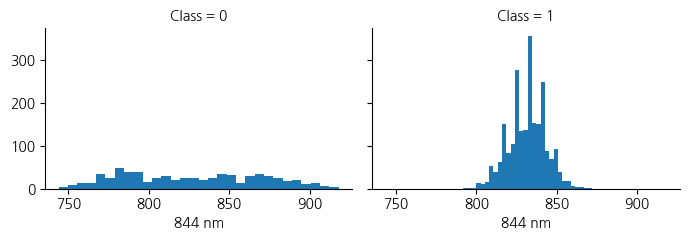

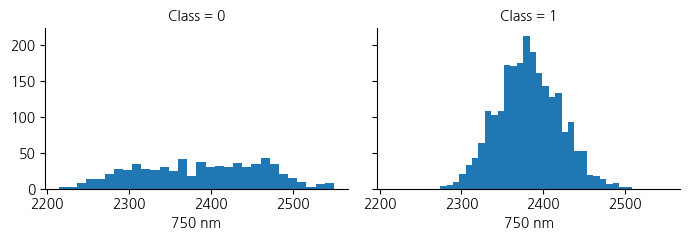

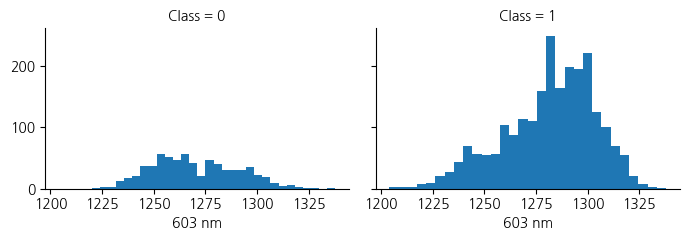

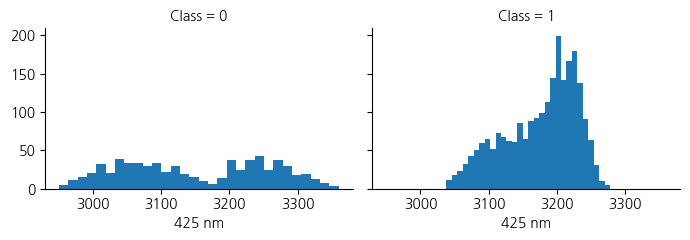

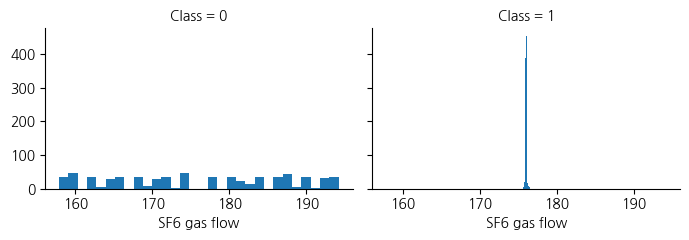

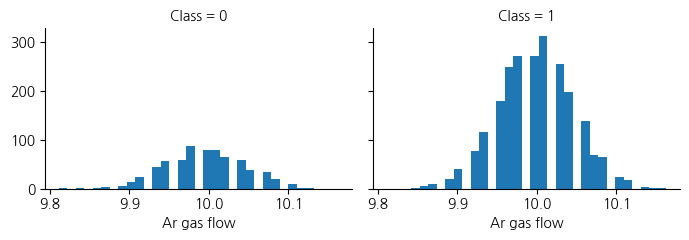

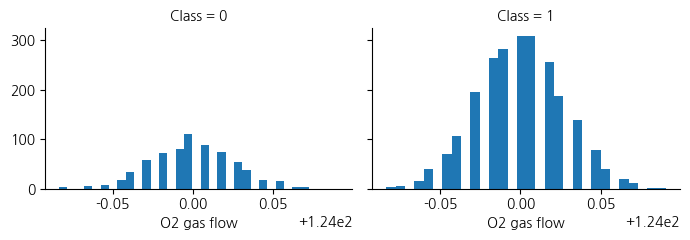

In [7]:
for i in range(len(data.columns)-1):
    g = sns.FacetGrid(data, col='Class', height=2.5, aspect=1.4)
    g.map(plt.hist, data.columns[i], bins=30)

<Axes: >

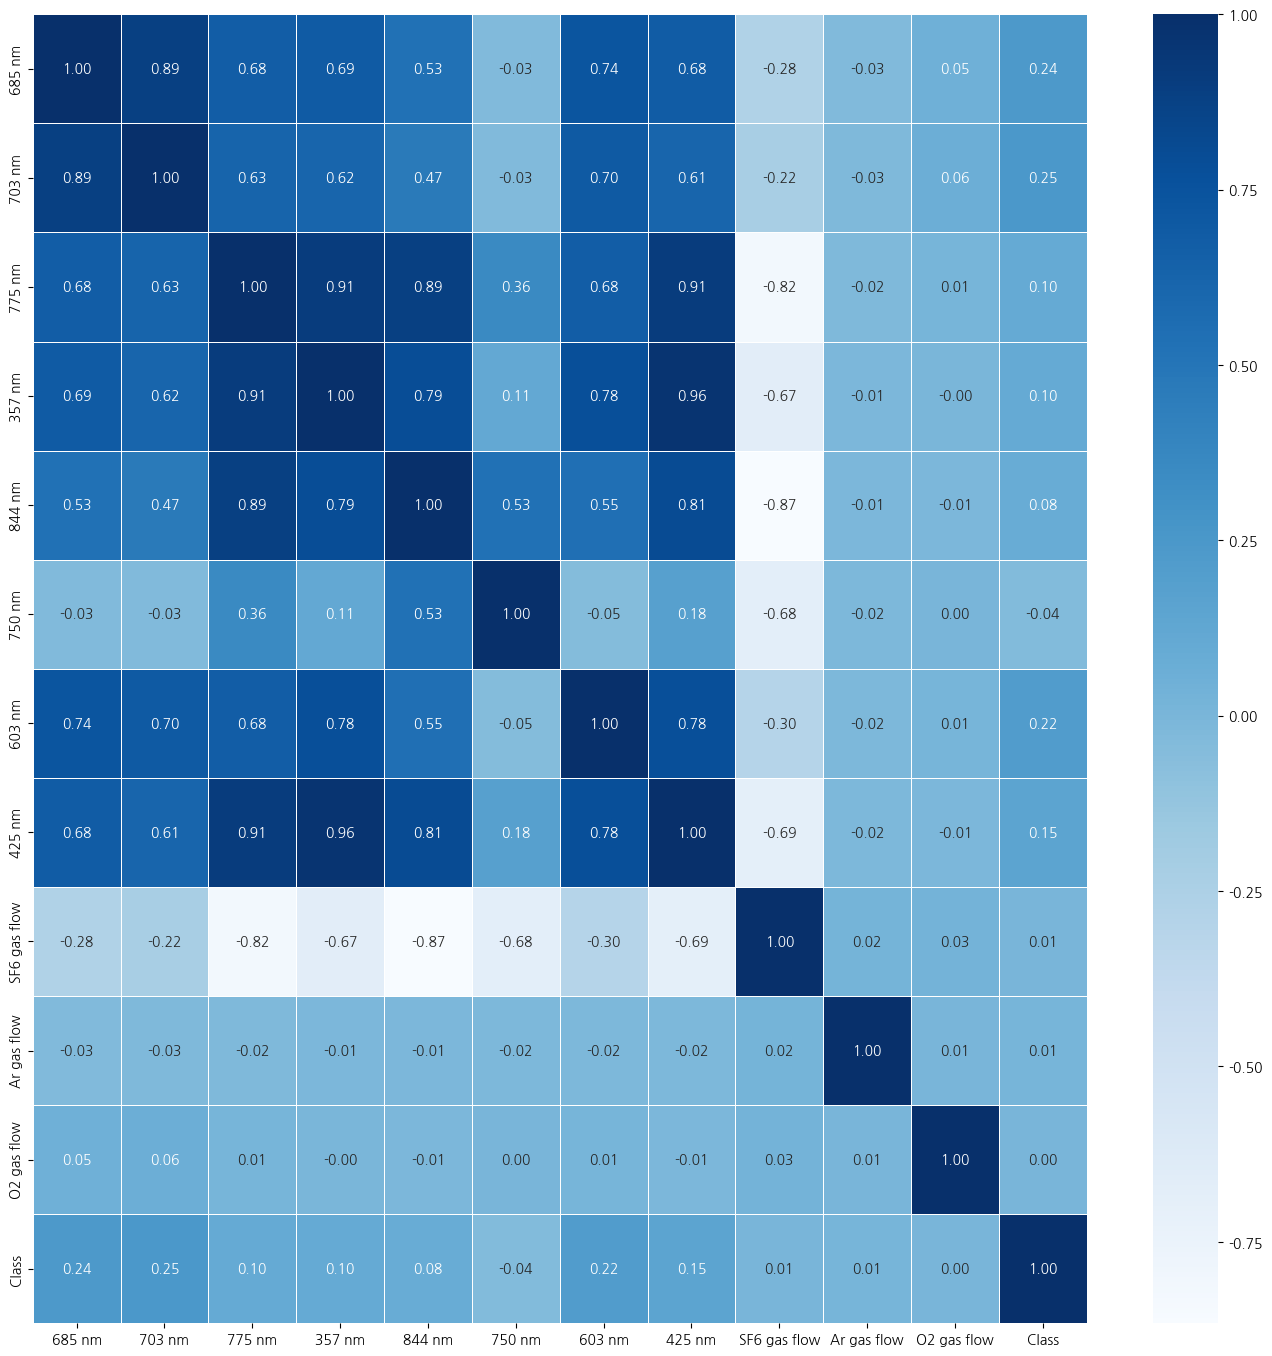

In [8]:
plt.figure(figsize=(17,17))
sns.heatmap(data = data.corr(method='pearson'), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')

In [9]:
X = data[data.columns[:-1]]
feature_name = X.columns

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = feature_name
print(vif)

       VIF Factor      features
0    21571.638272        685 nm
1    22046.547244        703 nm
2    22650.887108        775 nm
3    30395.621711        357 nm
4     9934.882673        844 nm
5     8725.483114        750 nm
6    14525.573109        603 nm
7    34026.119627        425 nm
8    15931.378234  SF6 gas flow
9    43405.453835   Ar gas flow
10  101234.063567   O2 gas flow


In [10]:
# 다중공선성 문제가 있으나, 별도의 전처리는 하지 않음

In [11]:
def test_scalers(data, use_nth=1, ax_size=6, legend_n_col=1):
    ''' ASSUME len(scalers) < 6
    '''
    print('\nScalers...')

#     ti = time.time()
    scalers = [StandardScaler(), RobustScaler(), Normalizer(), MinMaxScaler(), MaxAbsScaler()]
    names = ['StandardScaler', 'RobustScaler', 'Normalizer', 'MinMaxScaler', 'MaxAbsScaler']
    scaled_datas = [None for i in names]

    #names = names[:-1]
    axes = []
    n_row = 2
    n_col = len(names) // n_row + 1
    if len(names) % n_row:
        fig = plt.figure(figsize=(ax_size * n_col + ax_size / 3, ax_size * n_row))
        grid = (n_row, n_col * 3 + 1)
    else:
        fig = plt.figure(figsize=(ax_size * n_col, ax_size * n_row))
        grid = (n_row, n_col * 3)

    r, c = 0, 0
    debug = []
    #print(grid)
    for i in range(len(names)):
        debug.append((r, c * 3))
        axes.append(plt.subplot2grid(grid, (r, c*3), colspan=3))
        #print(f'{i}: {debug}')
        r = r + 1 if c == n_col - 1 else r
        c = 0 if c == n_col - 1 else c + 1
    debug.append((r, c * 3))
    #print(debug)
    axes.append(plt.subplot2grid(grid, (r, c*3), colspan=3))  # for raw data

    if len(names) % n_row:
        debug.append((0, (c+1)*3))
        axes.append(plt.subplot2grid(grid, (0, (c+1)*3), rowspan=n_row)) # for legend
    else:
        debug.append((r, (c+1)*3))
        axes.append(plt.subplot2grid(grid, (r, (c+1)*3), colspan=3)) # for legend
    #print(debug)
    #input('Enter...')

#     ti.start('Drawing scaled data...')
    plt.get_current_fig_manager().set_window_title('Scaled Data')
    #fig.suptitle('')

    X = np.arange(data.shape[0])
    markers = ['o', '^', 's', 'p', 'P', '*', 'X', 'D']

    for i in range(len(names)):
#         ti.start(f'[{names[i]}]...')
        axes[i].set_title(f'[{names[i]}]')

        scalers[i].fit(data)
        scaled_datas[i] = scalers[i].transform(data)
#         ti.stop()

        for j in range(scaled_datas[i].shape[1]):
            axes[i].scatter(
                X[::use_nth], scaled_datas[i][::use_nth,j],
                marker=markers[j%len(markers)], label=j, alpha=0.2
            )

    # raw data
    axes[-2].set_title('[Raw Data]')
    for j in range(data.shape[1]):
        axes[-2].scatter(
            X[::use_nth], data[::use_nth, j],
            marker=markers[j % len(markers)], label=j, alpha=0.2
        )

    # legend
    axes[-1].axis('off')
    for j in range(data.shape[1]):
        axes[-1].scatter([], [], marker=markers[j % len(markers)], label=j)

    plt.legend(loc='lower right', ncol=legend_n_col)
    #plt.subplots_adjust(right=0.9) # reserve right side for legend
    plt.tight_layout()
    plt.draw()
    plt.waitforbuttonpress(0.01)

#     ti.stop()

#     return scaled_datas, names


Scalers...


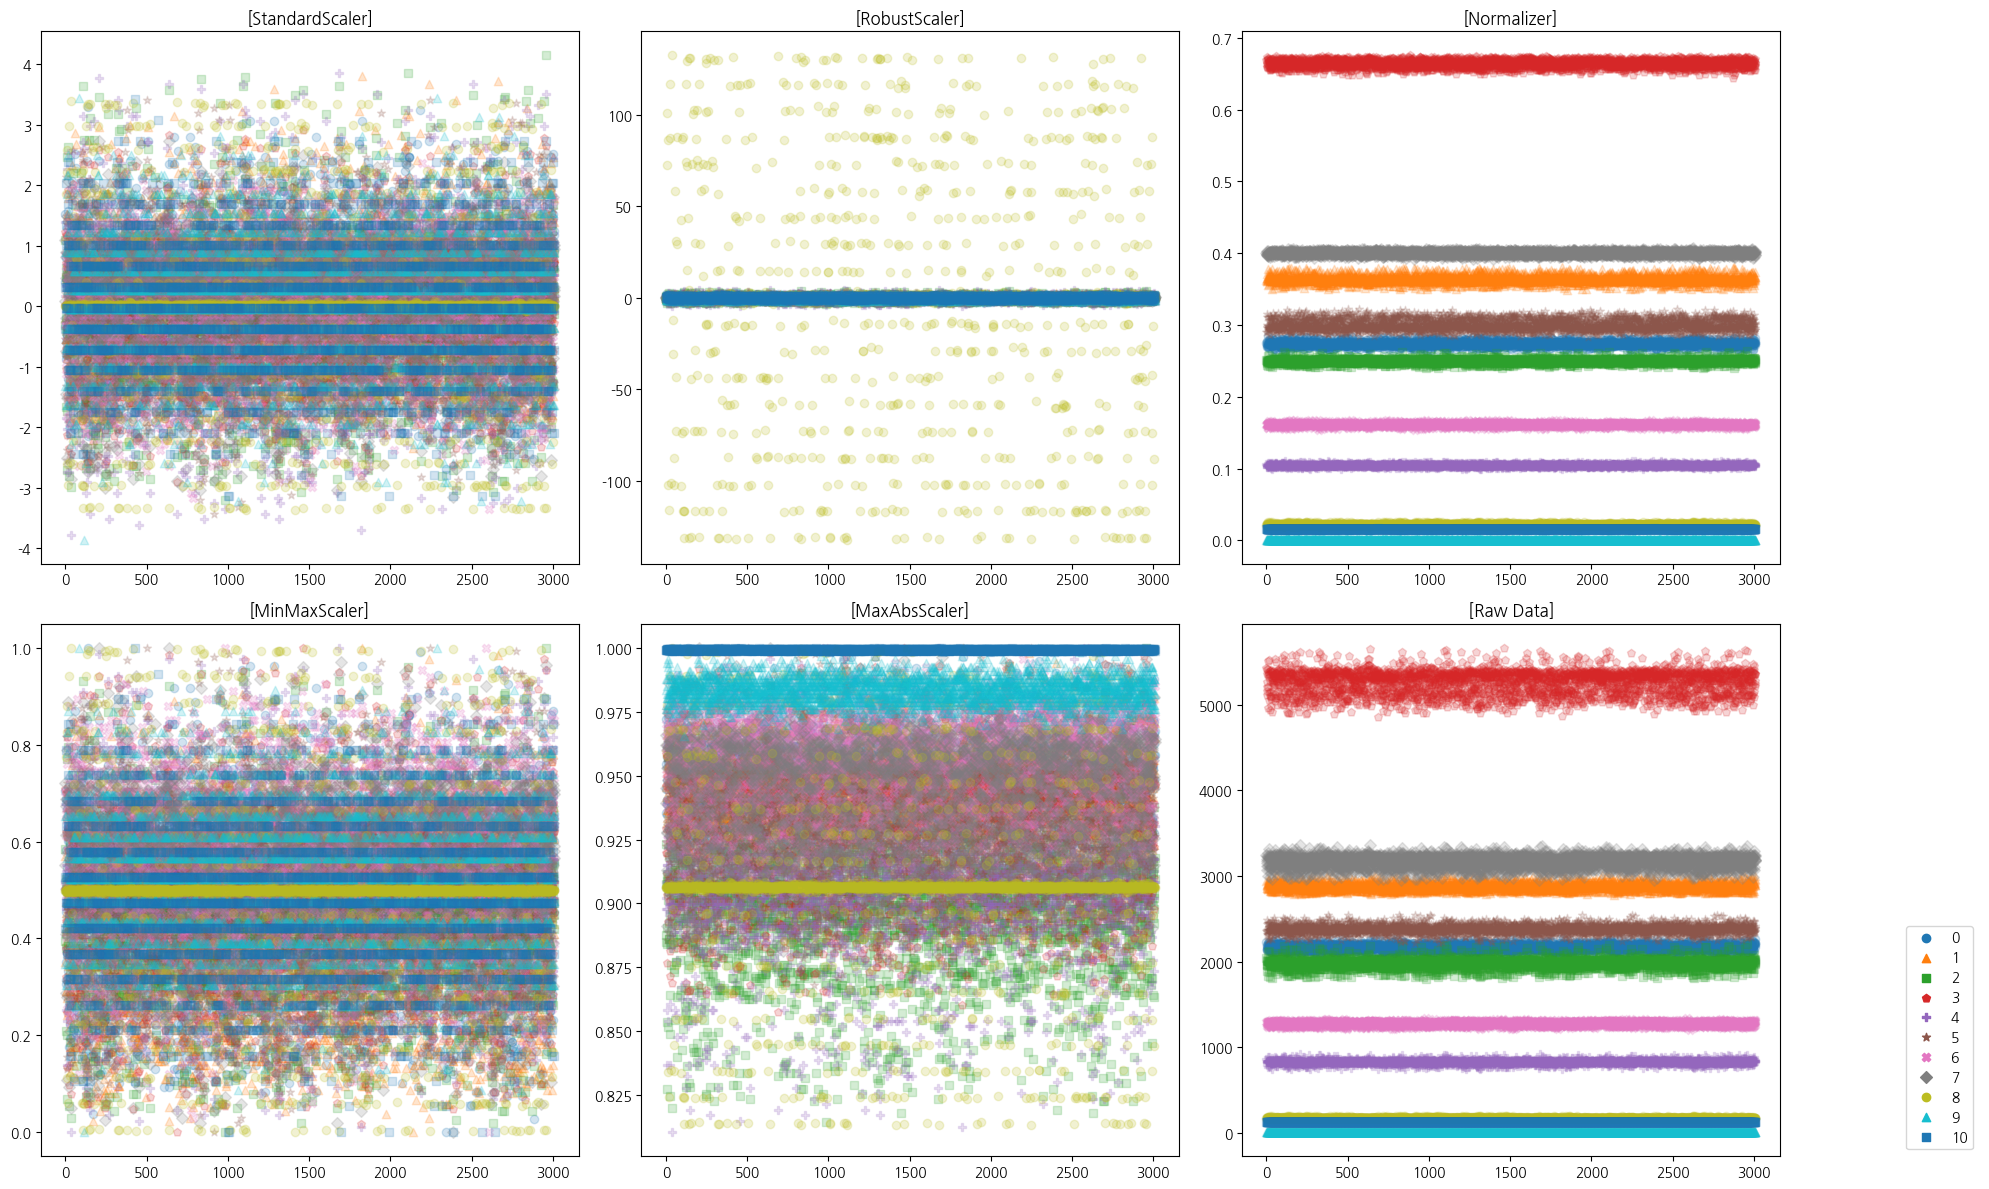

In [12]:
test_scalers(data=data[data.columns[:-1]].to_numpy())

In [13]:
scaler=StandardScaler()
scaler.fit(X)
X_norm =scaler.transform(X)

In [14]:
seed = 100
X_train, X_test, y_train, y_test = train_test_split(X_norm, data[data.columns[-1]].values, test_size=0.2, random_state=seed)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2408, 11), (602, 11), (2408,), (602,))

### 2. 머신러닝(Traditional)

In [16]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc_log = round(accuracy_score(y_test, y_pred) * 100, 2)
acc_log

77.57

In [17]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
acc_svc = round(accuracy_score(y_test, y_pred) * 100, 2)
acc_svc

96.18

In [18]:
# K Nearest Neighbor

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
acc_knn = round(accuracy_score(y_test, y_pred) * 100, 2)
acc_knn

95.85

In [19]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_pred = gaussian.predict(X_test)
acc_gaussian = round(accuracy_score(y_test, y_pred) * 100, 2)
acc_gaussian

96.84

In [20]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, y_train)
y_pred = perceptron.predict(X_test)
acc_perceptron = round(accuracy_score(y_test, y_pred) * 100, 2)
acc_perceptron

72.43

In [21]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(accuracy_score(y_test, y_pred) * 100, 2)
acc_linear_svc

78.07

In [22]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
acc_sgd = round(accuracy_score(y_test, y_pred) * 100, 2)
acc_sgd

78.74

In [23]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(accuracy_score(y_test, y_pred) * 100, 2)
acc_decision_tree

100.0

In [24]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
acc_random_forest = round(accuracy_score(y_test, y_pred) * 100, 2)
acc_random_forest

100.0

In [29]:
# XGBoost

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
acc_xgb = round(accuracy_score(y_test, y_pred) * 100, 2)
acc_xgb

100.0

In [30]:
# LightGBM

lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)
acc_lgb = round(accuracy_score(y_test, y_pred) * 100, 2)
acc_lgb

99.83

In [32]:
# CatBoost

cb = CatBoostClassifier(verbose=False)
cb.fit(X_train, y_train)
y_pred = cb.predict(X_test)
acc_cb = round(accuracy_score(y_test, y_pred) * 100, 2)
acc_cb

100.0

In [33]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'XGB', 'LGB', 'CatBoost'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree, acc_xgb, acc_lgb, acc_cb]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,100.00
8,Decision Tree,100.00
9,XGB,100.00
11,CatBoost,100.00
10,LGB,99.83
4,Naive Bayes,96.84
0,Support Vector Machines,96.18
1,KNN,95.85
6,Stochastic Gradient Decent,78.74
7,Linear SVC,78.07


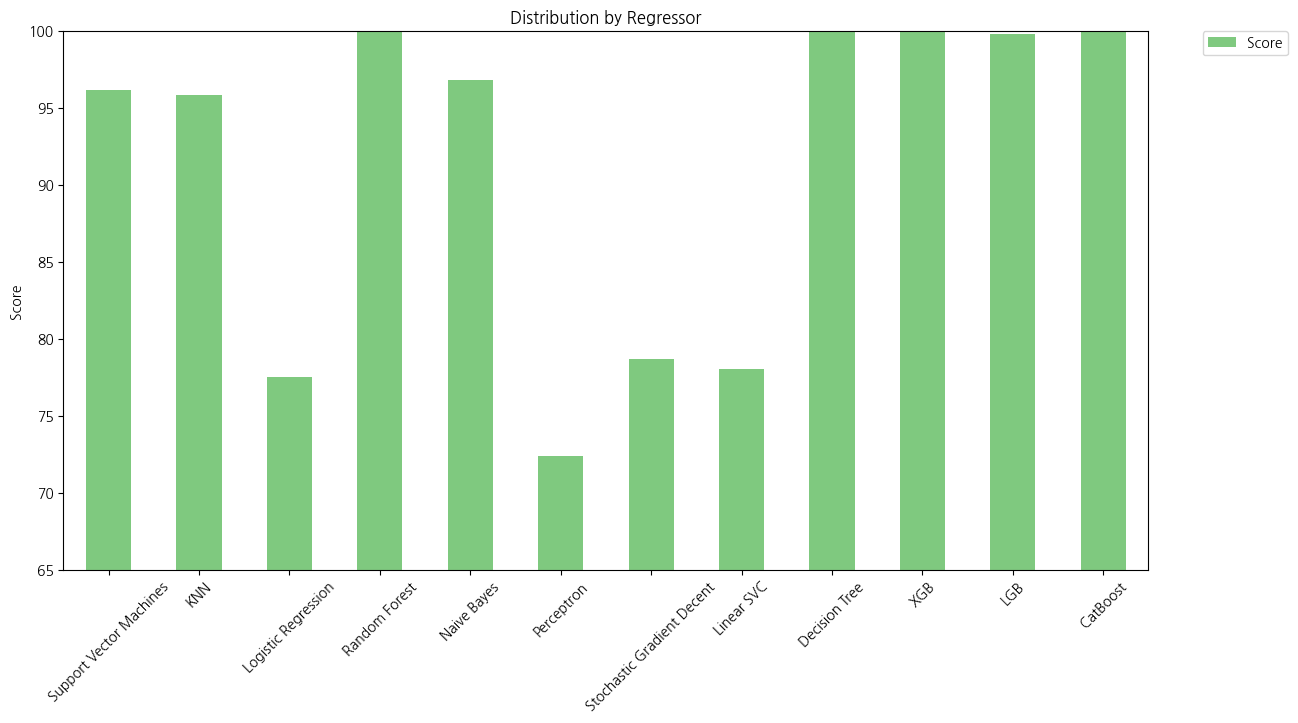

In [36]:
models.plot(kind='bar', ylim=(65.0,100.0), figsize=(14,7), align='center', colormap="Accent")
plt.xticks(np.arange(12), models['Model'])
plt.ylabel('Score')
plt.title('Distribution by Regressor')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
plt.show()

In [37]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

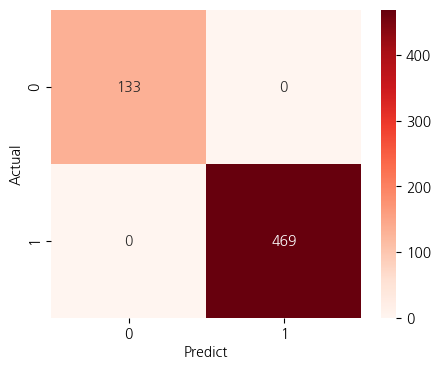

In [38]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Reds', fmt='.5g', annot_kws={"size": 10})
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

- 다수 모델의 ACC가 1로 측정되었으므로, hyperparameter 튜닝과정 생략

### 3. 딥러닝(FFN)

In [43]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout

In [44]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print('gpus', gpus)

gpus [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [89]:
def build_model(activation):
    model = tf.keras.Sequential()
    model.add(Dense(64, activation='relu', input_shape=[11]))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = activation

    model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    return model

In [90]:
o1 = tf.keras.optimizers.RMSprop()
o2 = tf.keras.optimizers.Adadelta()
o3 = tf.keras.optimizers.Adagrad()
o4 = tf.keras.optimizers.Adam()
o5 = tf.keras.optimizers.Adamax()
o6 = tf.keras.optimizers.Ftrl()
o7 = tf.keras.optimizers.Nadam()
o8 = tf.keras.optimizers.SGD()

model_lst = []
model_lst.append(build_model(o1))
model_lst.append(build_model(o2))
model_lst.append(build_model(o3))
model_lst.append(build_model(o4))
model_lst.append(build_model(o5))
model_lst.append(build_model(o6))
model_lst.append(build_model(o7))
model_lst.append(build_model(o8))

In [91]:
model_name = []
model_name.append('RMSprop')
model_name.append('Adadelta')
model_name.append('Adagrad')
model_name.append('Adam')
model_name.append('Adamax')
model_name.append('Ftrl')
model_name.append('Nadam')
model_name.append('SGD')

In [92]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')

EPOCHS = 500
history = []

# patience 매개변수는 성능 향상을 체크할 에포크 횟수
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

for i in range(len(model)):
    history.append(model_lst[i].fit(X_train, y_train, epochs=EPOCHS, validation_split = 0.3, verbose=0,
                                    shuffle=True, callbacks=[early_stop, PrintDot()]))


........................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.................................

In [93]:
hist = []
for i in range(len(history)):
    hist.append(pd.DataFrame(history[i].history))
    hist[i]['epoch'] = history[i].epoch

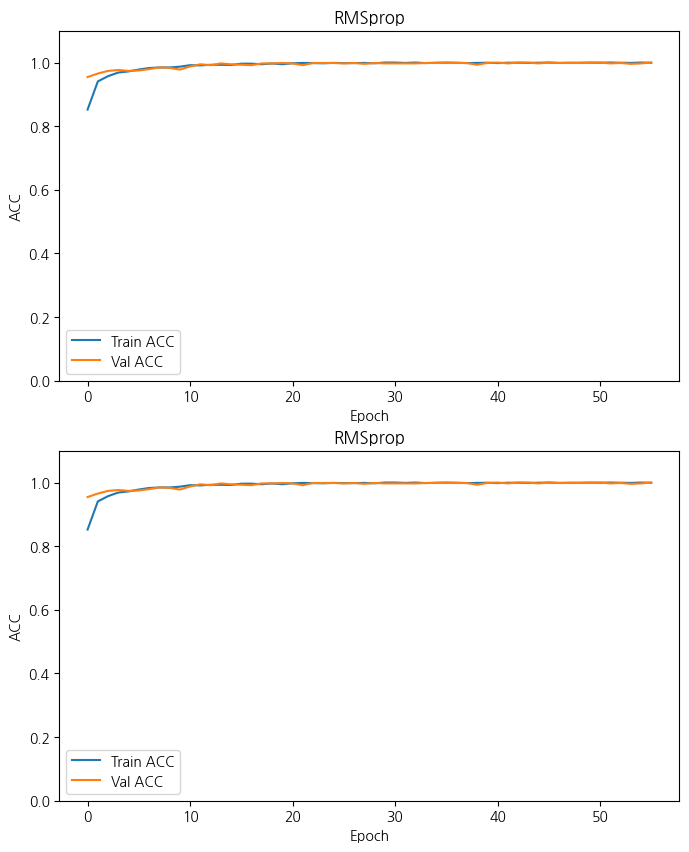

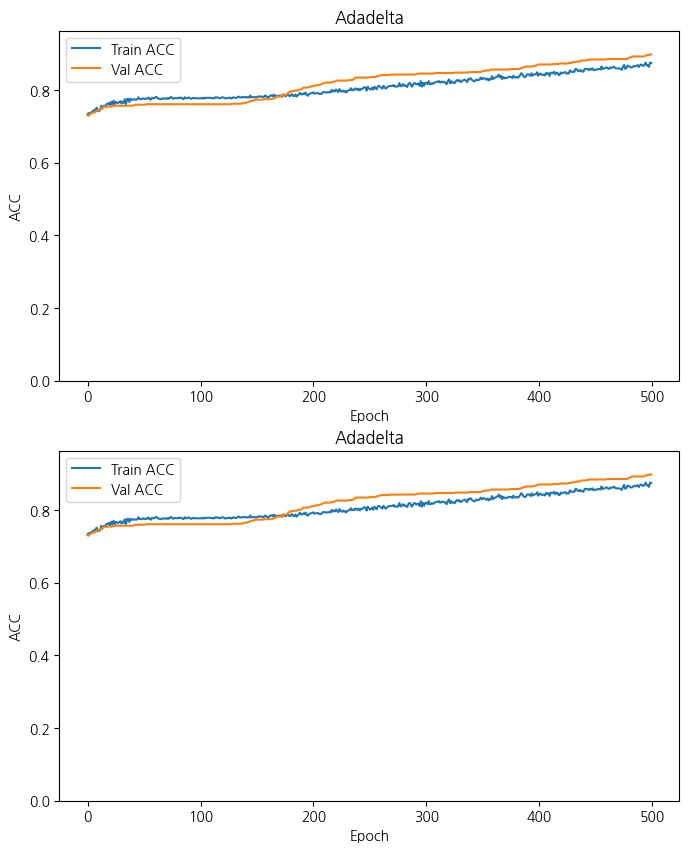

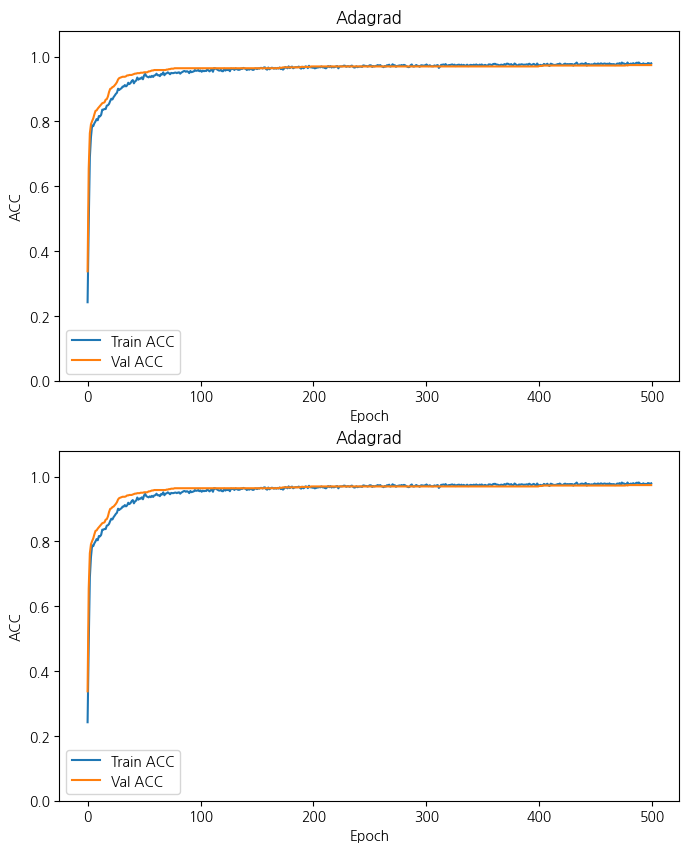

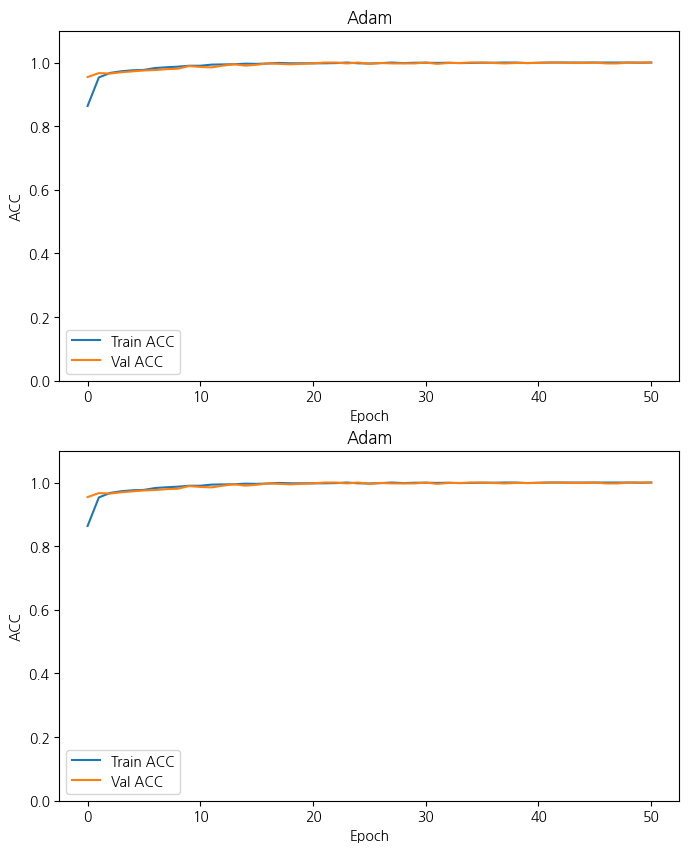

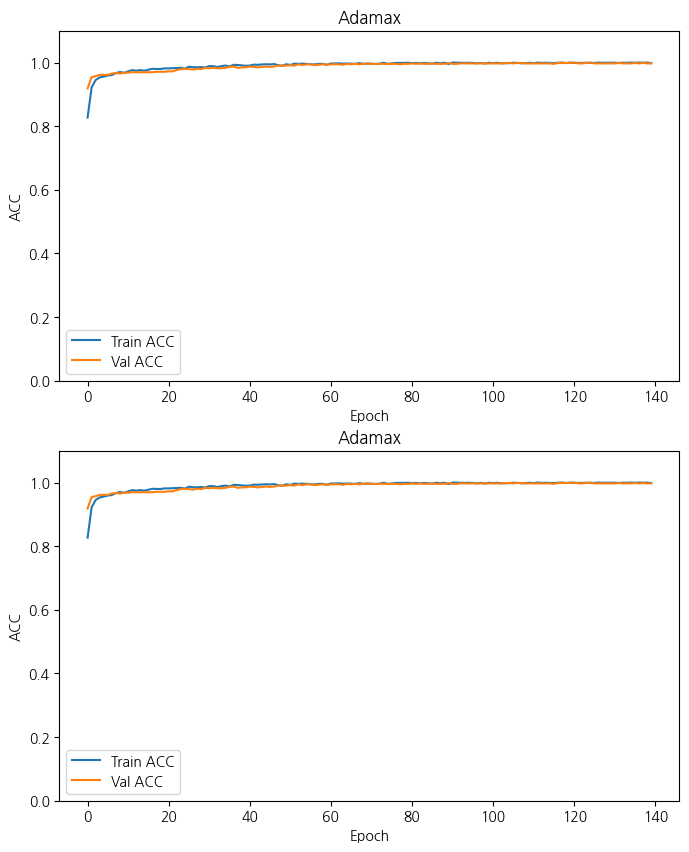

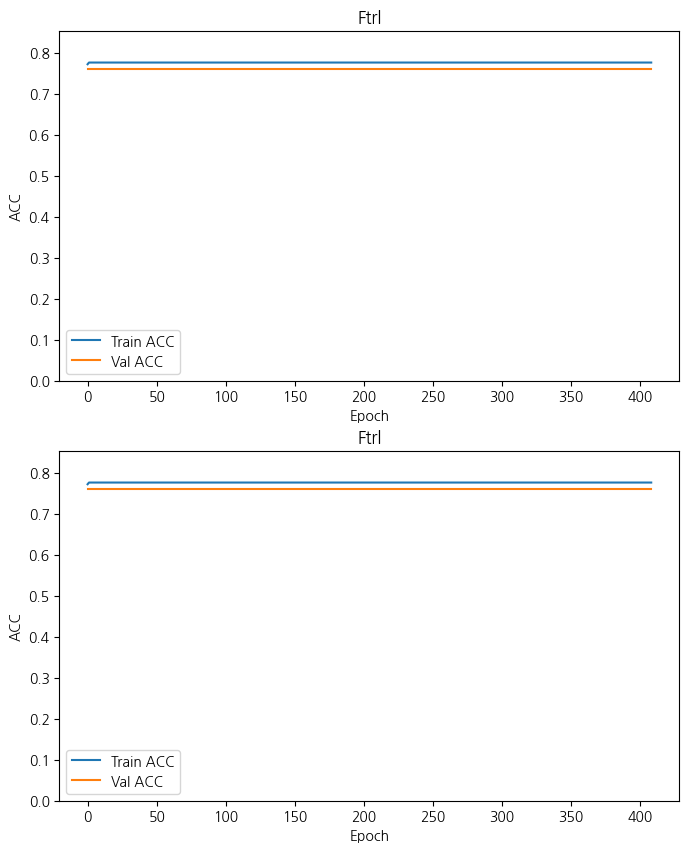

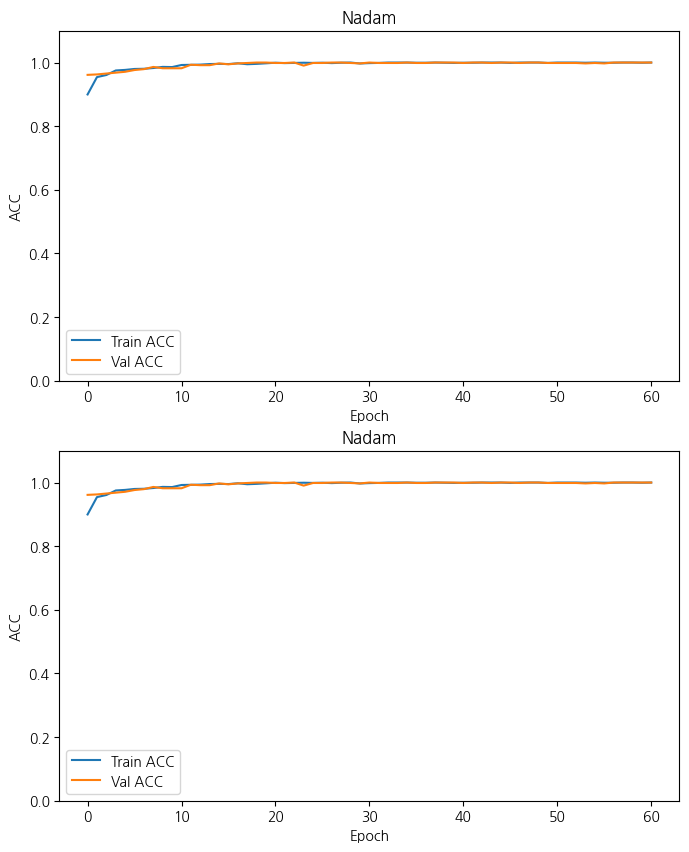

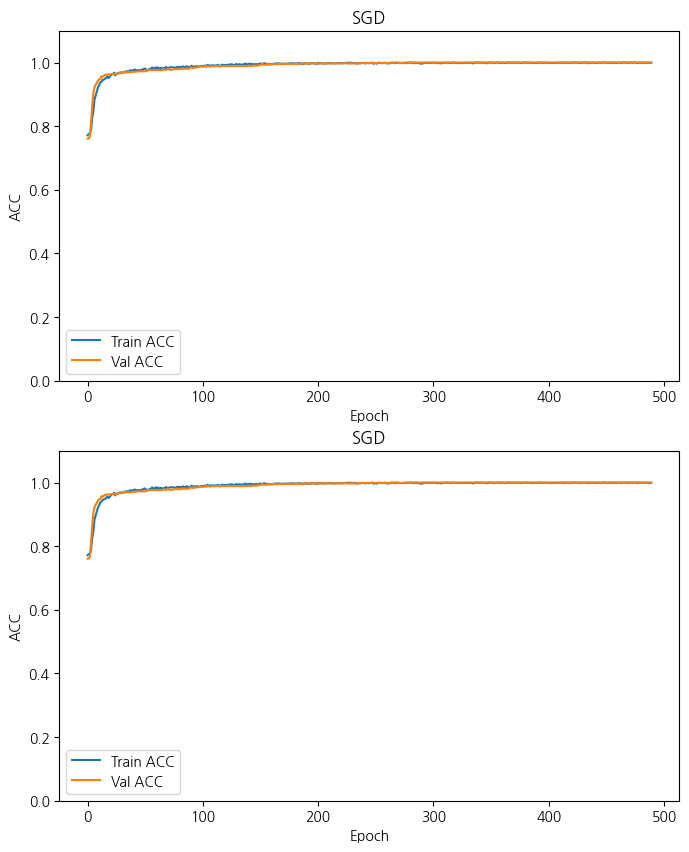

In [94]:
def plot_history(history):
    hist = []
    for i in range(len(history)):
        hist.append(pd.DataFrame(history[i].history))
        hist[i]['epoch'] = history[i].epoch

        plt.figure(figsize=(8,10))

        plt.subplot(2,1,1)
        plt.xlabel('Epoch')
        plt.ylabel('ACC')
        plt.plot(hist[i]['epoch'], hist[i]['accuracy'], label='Train ACC')
        plt.plot(hist[i]['epoch'], hist[i]['val_accuracy'], label = 'Val ACC')
        plt.ylim([0,hist[i]['accuracy'].max()*1.1])
        plt.title(model_name[i])
        plt.legend()

        plt.subplot(2,1,2)
        plt.xlabel('Epoch')
        plt.ylabel('ACC')
        plt.plot(hist[i]['epoch'], hist[i]['accuracy'], label='Train ACC')
        plt.plot(hist[i]['epoch'], hist[i]['val_accuracy'], label = 'Val ACC')
        plt.ylim([0,hist[i]['accuracy'].max()*1.1])
        plt.title(model_name[i])
        plt.legend()
        plt.show()

plot_history(history)

In [95]:
accuracy = []
for i in range(len(model)):
    loss_and_metrics = model_lst[i].evaluate(X_test, y_test, verbose=1)
    accuracy.append(loss_and_metrics[1])

19/19 [==============================] - 0s 712us/step - loss: 7.2377e-04 - accuracy: 1.0000


In [96]:
models_nn = pd.DataFrame({
    'Model': model_name,
    'Score': accuracy})
models_nn.sort_values(by='Score', ascending=False)

,Model,Score
3,Adam,1.000000
6,Nadam,1.000000
7,SGD,1.000000
0,RMSprop,0.996678
4,Adamax,0.996678
2,Adagrad,0.971761
1,Adadelta,0.875415
5,Ftrl,0.779070


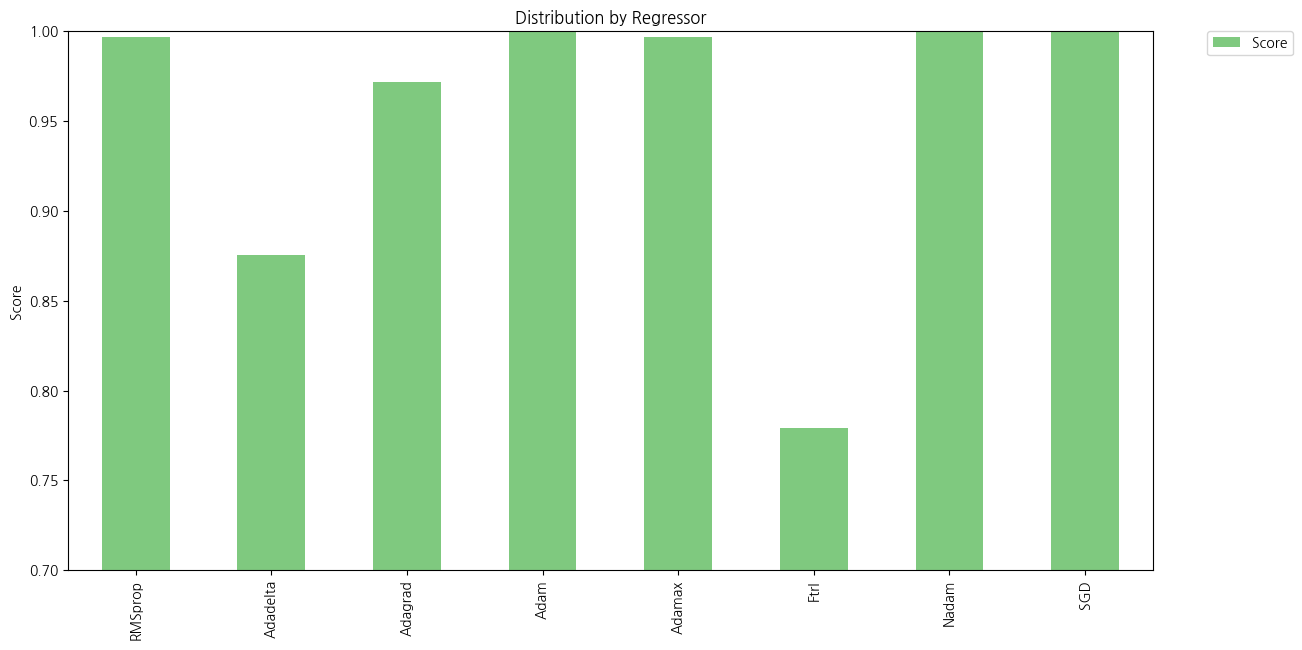

In [97]:
models_nn.plot(kind='bar', ylim=(0.70,1.0), figsize=(14,7), align='center', colormap="Accent")
plt.xticks(np.arange(8), models_nn['Model'])
plt.ylabel('Score')
plt.title('Distribution by Regressor')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [98]:
# opt = Adam

y_pred_nn = model_lst[3].predict(X_test)
y_pred_nn = [1 if prob > 0.5 else 0 for prob in y_pred_nn]

19/19 [==============================] - 0s 499us/step


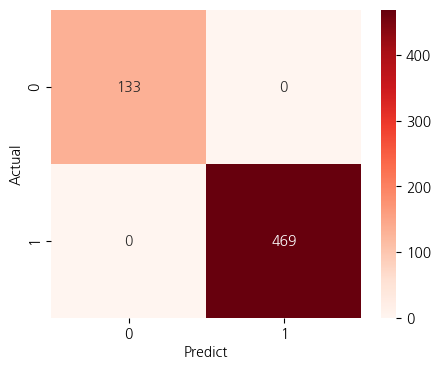

In [99]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_nn), annot=True, cmap='Reds', fmt='.5g', annot_kws={"size": 10})
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()